In [65]:
import torch
from agents.debn_ps import *
from environments.env_gridworld import *
from tqdm import tqdm 
from torchsummary import summary
from torch import tensor

import seaborn as sns

### **TEST RUN on AGENT/ENVIRONMENT/DEBN modules**

#### EXPERIMENTS on ENVIRONMENT

In [2]:
envs = TaskEnvironment((10,10)) ##(10x10 rectangular gridworld)

In [3]:
envs.num_percepts_list

(10, 10)

In [4]:
print('pos i:', envs.position )
envs.step(1)
envs.step(3)
print('pos f:', envs.position )

pos i: [0 0]
pos f: [0 0]


In [6]:
trajectory = []
for _ in tqdm(range(1000)):
    envs.step(np.random.choice([0,1,2,3]))
    trajectory.append(envs.position)


100%|██████████| 1000/1000 [00:00<00:00, 5283.12it/s]


#### EXPERIMENTS on DEBN 

In [10]:
net = DEBN(8,4,dim_hidden_=[6])

In [80]:
param_dict = dict([(item[0], item[1].data) for item in net.named_parameters()])
    
    
param_dict

{'visible.weight': tensor([[-0.0396,  0.1298, -0.0526, -0.0605, -0.4021, -0.4062, -0.2148, -0.6366,
           0.6963,  0.6717,  0.2940,  0.4957],
         [-0.6605,  0.3451,  0.3555, -0.4935,  0.0967, -0.3285,  0.0302,  0.4109,
          -0.5419, -0.4694,  0.6518, -0.5471],
         [ 0.2531,  0.0585,  0.6476, -0.5771, -0.5169,  0.0771, -0.6999, -0.1534,
          -0.0040, -0.5897, -0.0990, -0.0070],
         [-0.1227, -0.1482,  0.1690, -0.4544,  0.0503,  0.4100,  0.5283, -0.2683,
          -0.0019,  0.2410,  0.0396,  0.2383],
         [-0.5534, -0.3791,  0.4419, -0.3219, -0.5576, -0.0932, -0.1381, -0.4097,
          -0.2747,  0.4922, -0.5464,  0.1395],
         [ 0.0781, -0.0412,  0.4846,  0.7038, -0.5456, -0.0189, -0.5842, -0.0243,
          -0.6919,  0.6442, -0.3532, -0.1010]]),
 'visible.bias': tensor([-0.0505, -0.2618,  0.0659, -0.0226, -0.1042, -0.2786]),
 'b_input.weight': tensor([[-0.0408,  0.2446, -0.2440, -0.1015, -0.0279, -0.2168, -0.1427, -0.2328,
           0.0722,  0.242

In [82]:
np.append(param_dict['visible.bias'].numpy(), param_dict['b_input.weight'].numpy() )

array([-0.05051669, -0.26176426,  0.06592607, -0.02258434, -0.10423838,
       -0.27863848, -0.04080069,  0.24458791, -0.24395695, -0.10152031,
       -0.02794464, -0.2167844 , -0.14266838, -0.23284821,  0.07220743,
        0.24231963,  0.14297189, -0.09822213], dtype=float32)

<AxesSubplot:>

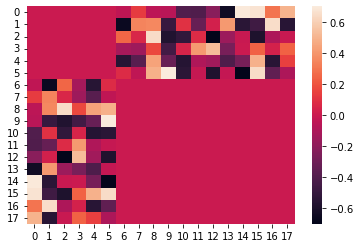

In [78]:
params = list(net.named_parameters())

a = param_dict['visible.weight'].numpy()
# a = a.transpose()

z0 = np.zeros((a.shape[0],a.shape[0]))
z1 = np.zeros((a.shape[1],a.shape[1]))

up = np.concatenate((z0, a), axis= 1)
down = np.concatenate( (a.transpose(), z1), axis= 1)

mat = np.concatenate((up,down), axis= 0)

sns.heatmap(mat)

In [83]:
from qumcmc.energy_models import IsingEnergyFunction
def build_energy_model(net: DEBN):
    """ Works with only single hidden layer type RBMs """
    
    model_dim = net.visible.in_features + net.visible.out_features
    # named_params = list(net.named_parameters())
    param_dict = dict([(item[0], item[1].data) for item in net.named_parameters()])

    interactions = param_dict['visible.weight'].numpy()
    z0 = np.zeros((a.shape[0],a.shape[0])); z1 = np.zeros((a.shape[1],a.shape[1]))
    up = np.concatenate((z0, a), axis= 1); down = np.concatenate( (a.transpose(), z1), axis= 1)
    J = np.concatenate((up,down), axis= 0)

    biases = np.append(param_dict['visible.bias'].numpy(), param_dict['b_input.weight'].numpy() )

    ##checks
    assert model_dim == len(biases)
    assert model_dim == J.shape[0] 

    ##construct model
    model = IsingEnergyFunction(J, biases, "DEBN")

    return model

  

In [85]:
net_model = build_energy_model(net)

In [33]:
params= list(net.parameters())

In [89]:
from qumcmc.classical_mcmc_routines import * 
from qumcmc.quantum_mcmc_routines_qulacs import *

In [34]:
len(params)

10

In [35]:
for i in range(len(params)):
    print(params[i].shape)

torch.Size([6, 4])
torch.Size([6])
torch.Size([1, 4])
torch.Size([1])
torch.Size([5, 6])
torch.Size([5])
torch.Size([4, 5])
torch.Size([4])
torch.Size([1, 5])
torch.Size([1])


In [36]:
print(net)

DEBN(
  (visible): Linear(in_features=4, out_features=6, bias=True)
  (b_input): Linear(in_features=4, out_features=1, bias=True)
  (hidden): ModuleList(
    (0): Linear(in_features=6, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=4, bias=True)
  )
  (output): Linear(in_features=5, out_features=1, bias=True)
  (dropout): ModuleList(
    (0): Dropout(p=0.0, inplace=False)
  )
)


In [37]:
percept = tensor([[1.0,0,0,0]], dtype= float ); action = tensor([[0,1.0]], dtype= float)


In [38]:
torch.cat((percept, action), dim= 1)

tensor([[1., 0., 0., 0., 0., 1.]], dtype=torch.float64)

In [39]:
from torch import nn


In [40]:
tnet = nn.Linear(2,1)
tnet.weight , tnet.bias

(Parameter containing:
 tensor([[ 0.5851, -0.5535]], requires_grad=True),
 Parameter containing:
 tensor([0.4076], requires_grad=True))

#### Experiments on AGENTS

In [6]:
# INTERACTION PARAMETERS #
#------------------------#
EPISODES = 100  # number of episodes for each agent 2000
MAX_STEPS_PER_TRIAL = 50  # number of allowed timesteps before reset 20000

#agent parameters
AGENT_NUMBER = 1
DEVICE = 'cpu'
AGENT_NAME = 'ebm'

GAMMA = 0.99 # discount factor
hidden_layers = 5 # number of hidden layers
hidden_units_layer = 64 # number of hidden units
NUM_HIDDEN = [int(round(hidden_units_layer))]*hidden_layers # list of hidden unit numbers list
DROPOUT = [0.]*hidden_layers # dropout rate list
LEARNING_RATE = 0.001 # learning rate
CAPACITY = 500 # size of the memory
BATCH_SIZE = 100 # size of the training batch for experience replay
REPLAY_TIME = 50 # the time interval between each experience replay
TARGET_UPDATE = 100 # update interval for the target network
SAVE_MODEL = False #set to true to save state dict

BETA_i = 0.001 # initial beta parameter for schedule
BETA_f = 0.08 # final beta parameter for schedule
SCHEDULE = 'htan' # name of the schedule
if SCHEDULE == 'htan':
    beta = np.tanh(np.linspace(BETA_i, BETA_f, EPISODES)) # tanh schedule
elif SCHEDULE =='lin':
    beta = np.linspace(BETA_i, BETA_f, EPISODES) # linear scchedule

# ENVIRONMENT PARAMETERS
ENV_NAME = 'gridworld' # environment name
DIMENSIONS = [10,10] # 2D grid of size [10,10]
env = TaskEnvironment(DIMENSIONS) #generate environment

## 'percept_size' depends on the encdoing 
percept_size_oneh = DIMENSIONS[0]*DIMENSIONS[1] #size of the percept space 
percept_size_twoh = DIMENSIONS[0]+DIMENSIONS[1] #size of the percept space

action_size = 4 # size of the action space

#action encoding
all_actions = torch.empty(0)
for i in range(action_size):
    a = torch.zeros((1, 1, action_size))
    a = a.new_full((1, 1, action_size), 0.)
    a[0, 0, i] = 1.
    all_actions = torch.cat((all_actions, a))

#percept encoding
def to_two_hot(percept, dim):
    """
    Two-hot encodes the 2D percept of positions.
    """
    two_hot = np.zeros(dim[0]+dim[1]) ##added
    two_hot[percept[0]] = 1
    two_hot[dim[0]+percept[1]] = 1
    return two_hot


#percept encoding
def to_one_hot(percept, dim):
    """
    One-hot encodes the 2D percept of positions.
    """
    one_hot = np.zeros(dim[0]*dim[1]) ## multiplied
    
    one_hot[dim[0]*percept[0] + percept[1]] = 1
    
    return one_hot    


In [7]:
# DEFINE AGENT           #
#------------------------#
agent = DEBNAgent(percept_size_twoh, action_size, all_actions, dim_hidden=NUM_HIDDEN, dropout_rate=DROPOUT,
                    device = DEVICE, learning_rate=LEARNING_RATE, capacity=CAPACITY, batch_size=BATCH_SIZE, replay_time=REPLAY_TIME,
                    target_update = TARGET_UPDATE, gamma = GAMMA, train_output_weights = False)


In [8]:
counter = 0
#reset the environment
percept = env.reset()
percept = to_two_hot(percept, DIMENSIONS)
percept = np.reshape(percept, [1, percept_size_twoh])
percept = torch.Tensor(percept)
reward = 0.
done = False

In [9]:
agent.deliberate(percept, 1)

tensor([[0., 0., 1., 0.]])

In [10]:
action = agent.deliberate_and_learn(percept, None, reward, GAMMA, done, 1.00)
action = (action[0] == 1).nonzero().item()

In [11]:
env.step(action)

(array([0, 0]), 0.0, False, None)

In [12]:
agent._memory ## memory can only be accessed by the -> ._experience_replay function.

deque([])

In [13]:
EPISODES = 100
MAX_STEPS_PER_TRIAL = 100
verbose = False
coords = []
# RUN TRAINING STEPS     #
#------------------------#
timesteps = []
for e in tqdm(range(EPISODES), desc= 'running episodes'):
    counter = 0
    #reset the environment
    percept = env.reset()
    coords.append(percept) ## coords stroing 
    # percept = to_one_hot(percept,DIMENSIONS)
    # percept = np.reshape(percept, [1, percept_size_oneh])
    percept = to_two_hot(percept,DIMENSIONS)
    percept = np.reshape(percept, [1, percept_size_twoh])
    percept = torch.Tensor(percept)
    reward = 0.
    done = False
    # for t in tqdm(range(1, MAX_STEPS_PER_TRIAL + 1), desc= 'runnnig episode . .. '+str(e) ):
    for t in range(1, MAX_STEPS_PER_TRIAL + 1):
        
        action = agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
        action = (action[0] == 1).nonzero().item()
        percept, reward, done, _ = env.step(action)
        coords.append(percept) ## coords storing 

        if verbose :  print('action : '+str( action) + ' percept : ' + str(percept) + ' reward : '+ str( reward))
        # percept = to_one_hot(percept, DIMENSIONS)
        # percept = np.reshape(percept, [1, percept_size_oneh])
        percept = to_two_hot(percept,DIMENSIONS)
        percept = np.reshape(percept, [1, percept_size_twoh])
        percept = torch.Tensor(percept)
        
        if t==MAX_STEPS_PER_TRIAL:
            reward = -1
            done = True
        if done:
            agent.deliberate_and_learn(percept, None, reward, GAMMA, done, beta[e])
            timesteps.append(t)
            break

    if e%100 == 0:
        if verbose : print("Average last 100 scores (timesteps per episode) the agent achieved at " + str(e) + ": ", np.mean(timesteps[-100:]))
        # save data to file


running episodes: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


In [14]:
for items in agent.policy_net.named_parameters():
    print('name: ', items[0])
    print(items[1])

name:  visible.weight
Parameter containing:
tensor([[ 0.0449, -0.2254, -0.4175,  ...,  0.0458,  0.3926, -0.0613],
        [-0.4060,  0.4356, -0.2775,  ..., -0.3680,  0.3119,  0.3668],
        [ 0.0592,  0.2603, -0.2611,  ...,  0.4962,  0.4127, -0.2776],
        ...,
        [-0.3497,  0.4776,  0.1852,  ...,  0.4501, -0.2937, -0.2344],
        [ 0.0961,  0.3703, -0.4555,  ..., -0.4946, -0.2124, -0.0314],
        [ 0.0401, -0.4553,  0.0347,  ...,  0.0938,  0.2364, -0.3500]],
       requires_grad=True)
name:  visible.bias
Parameter containing:
tensor([ 0.0536,  0.1416,  0.1019, -0.2162,  0.1122,  0.1202, -0.0601, -0.1794,
        -0.1176, -0.1909, -0.1880, -0.0050, -0.0583,  0.1286,  0.1195, -0.0009,
         0.1337, -0.1534,  0.1513, -0.0972, -0.0113,  0.1527, -0.1549, -0.1757,
         0.1373,  0.0723, -0.0173,  0.0557, -0.1566,  0.0817, -0.0437, -0.1931,
        -0.1572,  0.1767,  0.0347, -0.1259, -0.1572, -0.0654, -0.1528, -0.0699,
        -0.0284,  0.0332,  0.0488, -0.0044,  0.1765, 

In [49]:
xs = []; ys = []
for coord in coords: 
    xs.append(coord[0])
    ys.append(coord[1])

In [50]:
import matplotlib
%matplotlib inline 
import  matplotlib.pyplot as plt
from IPython.display import display, clear_output


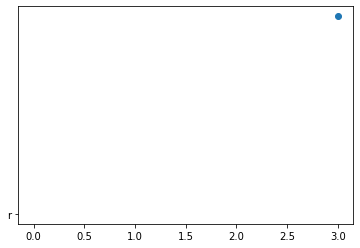

100%|██████████| 193/193 [00:28<00:00,  6.77it/s]


In [51]:
## visualise trajectory dynamically ## not very efficeint
plt.figure(figsize=(12,12))
for coord in tqdm(coords[::50]) :
    plt.plot(coord[0], coord[1], 'o', 'r')
    clear_output(wait= True)
    plt.show()
# plt.scatter(xs, ys )


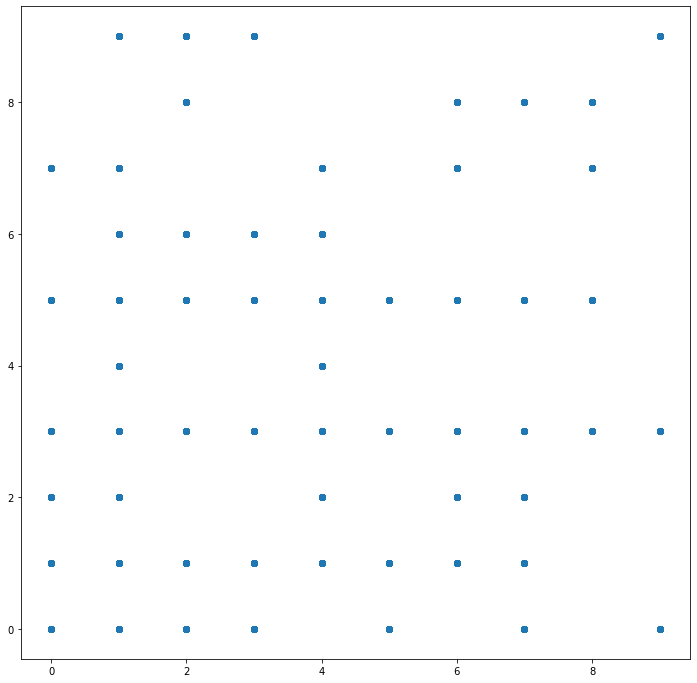

In [52]:
## visualise spots visited  ##
plt.figure(figsize=(12,12))
# for coord in tqdm(coords) :
#     plt.plot(xs, ys, '-o', 'r')
plt.scatter(xs, ys )
plt.show()